This notebook shows an example of using the Multi output module on a Lenet5 for uncertainty Quantification

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.metrics import log_loss, mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import datasets, transforms
from torchmetrics import CalibrationError

from models.lenet import LeNet5
from multi_output_module.multi_output_module import Multi_output_module

In [ ]:
data_path = './data'
batch_size = 32
num_classes = 10

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Load the MNIST dataset
mnist_train_dataset = datasets.MNIST(root=data_path,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

mnist_test_dataset = datasets.MNIST(root=data_path,
                                    train=False,
                                    transform=transforms.ToTensor())

mnist_ood_dataset = datasets.FashionMNIST(root=data_path,
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=True)

train_size = int(0.8 * len(mnist_train_dataset))
val_size = len(mnist_train_dataset) - train_size
mnist_train_dataset, mnist_val_dataset = random_split(mnist_train_dataset, [train_size, val_size])

train_loader = DataLoader(mnist_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(mnist_val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(mnist_test_dataset, batch_size=32, shuffle=True)
fashion_ood_loader = DataLoader(mnist_ood_dataset, batch_size=32, shuffle=True)

# Define the transformation for CIFAR-100 dataset
cifar100_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert CIFAR-100 images to grayscale
    transforms.Resize((28, 28)),                 # Resize to match MNIST image size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

cifar100_dataset = datasets.CIFAR100(root=data_path, train=False, transform=cifar100_transform, download=True)
cifar100_ood_loader = DataLoader(cifar100_dataset, batch_size=32, shuffle=True, num_workers=2)

Files already downloaded and verified


In [ ]:
base_model = LeNet5()

# Load the state dictionary from the .pth file
base_model.load_state_dict(torch.load('./models/saved_models/mnist/mnist_lenet5.pth'))

base_model = base_model.to(device)

In [5]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    return accuracy

accuracy = test(base_model, device, test_loader)
print(f'Reloaded model test accuracy: {accuracy:.2f}%')

Test set: Average loss: 0.0517, Accuracy: 9849/10000 (98.49%)

Reloaded model test accuracy: 98.49%


In [6]:
num_heads = 3
batch_size = 16
num_classes = 10

In [7]:
base_model.eval()
    
module = Multi_output_module(num_heads, base_model, device).to(device)
print(module)

#optimizer = optim.Adam(module.parameters(), lr=0.0008, weight_decay= 0.0005)

optimizer = optim.Adam(module.parameters(), lr=0.0001)

criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(
    mnist_train_dataset,
    batch_size = num_heads* batch_size,
    shuffle=True,
    drop_last=True,
)

Multi_output_module(
  (activation): ReLU()
  (base_model): LeNet5(
    (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=256, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )
  (last_layer): Linear(in_features=84, out_features=10, bias=True)
  (input_heads): ModuleList(
    (0-2): 3 x Linear(in_features=84, out_features=10, bias=True)
  )
  (shared_layers): Linear(in_features=30, out_features=30, bias=True)
  (output_layers): ModuleList(
    (0-2): 3 x Linear(in_features=30, out_features=10, bias=True)
  )
)


In [8]:
total_params = sum(p.numel() for p in module.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 48836


In [ ]:
# Early stopping parameters
patience = 5
best_loss = float('inf')
epochs_no_improve = 0
num_epochs = 100  # Set a high number of epochs

#optimizer = optim.Adam(module.parameters(), lr=0.00001, weight_decay=0)

step = 0
for epoch in range(num_epochs):
    module.train()

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        step += 1

        #step = batch_idx + len(train_loader)*epoch+1

        labels = labels.view(-1, num_heads)

        optimizer.zero_grad()
        predictions = module(images, 'training')


        total_loss = 0
        for i in range(num_heads):
            total_loss += criterion(predictions[:, i, :], labels[:, i])
        total_loss /= num_heads

        total_loss.backward()
        optimizer.step()

        loss = total_loss.item()

        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(images)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss:.6f}")

    module.eval()
    val_loss = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            predictions = module(images, 'inference')
            
            mimo_output_avg = predictions.mean(dim=1)
            val_loss += criterion(mimo_output_avg, labels).item()
            _, predicted = torch.max(mimo_output_avg, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / total
    print(f'Epoch {epoch}, Val Loss: {val_loss:.6f}, Accuracy: {correct}/{len(val_loader.dataset)} ({accuracy:.2f}%)')

    '''
    wandb.log({
        "Iter step": step,
        "valid/accs": accuracy,
        #"test/accs": test_accs_b,
        #"valid/best_acc": self.best_valid_acc_b,
        #"test/best_acc": self.best_test_acc_b,
    })
    '''

    # Check for early stopping based on test loss
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
        best_model_state = module.state_dict()
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

module.load_state_dict(best_model_state)

#wandb_switch('Multi output module', 'First run', 0, 'finish')

Train Epoch: 0 [0/48000 (0%)]	Loss: 4.570747
Train Epoch: 0 [4800/48000 (10%)]	Loss: 3.690549
Train Epoch: 0 [9600/48000 (20%)]	Loss: 2.701743
Train Epoch: 0 [14400/48000 (30%)]	Loss: 2.326173
Train Epoch: 0 [19200/48000 (40%)]	Loss: 2.283152
Train Epoch: 0 [24000/48000 (50%)]	Loss: 2.171135
Train Epoch: 0 [28800/48000 (60%)]	Loss: 1.769102
Train Epoch: 0 [33600/48000 (70%)]	Loss: 1.934822
Train Epoch: 0 [38400/48000 (80%)]	Loss: 1.685667
Train Epoch: 0 [43200/48000 (90%)]	Loss: 1.832784
Epoch 0, Val Loss: 0.003881, Accuracy: 11884/12000 (99.03%)
Train Epoch: 1 [0/48000 (0%)]	Loss: 1.531632
Train Epoch: 1 [4800/48000 (10%)]	Loss: 1.492050
Train Epoch: 1 [9600/48000 (20%)]	Loss: 1.575234
Train Epoch: 1 [14400/48000 (30%)]	Loss: 1.556983
Train Epoch: 1 [19200/48000 (40%)]	Loss: 1.241067
Train Epoch: 1 [24000/48000 (50%)]	Loss: 1.196264
Train Epoch: 1 [28800/48000 (60%)]	Loss: 1.100542
Train Epoch: 1 [33600/48000 (70%)]	Loss: 0.843922
Train Epoch: 1 [38400/48000 (80%)]	Loss: 1.116934
Trai

<All keys matched successfully>

CIFAR10 Train set:
Average Entropy for Base Model Outputs: 0.0235
Average Entropy for Multi Outputs: 0.0230
CIFAR10 Test set:
Average Entropy for Base Model Outputs: 0.0258
Average Entropy for Multi Outputs: 0.0244
FashionMNIST OOD set:
Average Entropy for Base Model Outputs: 0.4406
Average Entropy for Multi Outputs: 0.5334
CIFAR100 OOD set:
Average Entropy for Base Model Outputs: 0.6094
Average Entropy for Multi Outputs: 0.7213


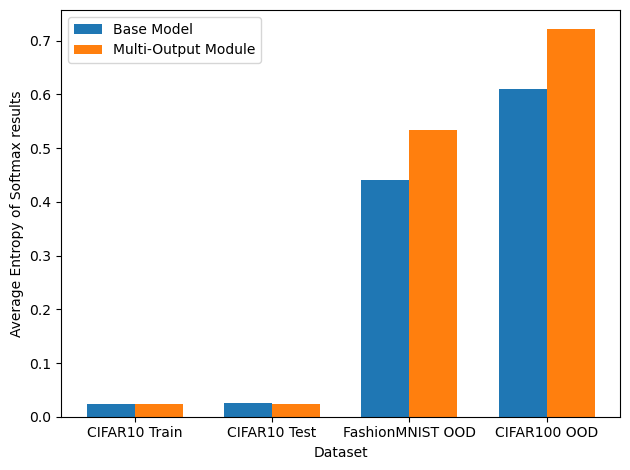

In [ ]:
# Function to compute and print the mean entropy of softmax outputs for base_model and module
def compute_mean_entropy_of_mean_softmax(loader, base_model, module, device):
    base_model.eval()
    module.eval()

    total_base_entropy_sum = 0
    total_multi_output_entropy_sum = 0
    num_samples = 0

    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            batch_size = images.size(0)
            num_samples += batch_size

            # Base model prediction and entropy calculation
            base_outputs = base_model(images)
            base_output_softmax = F.softmax(base_outputs, dim=1).cpu().numpy()
            base_entropies = np.sum(entropy(base_output_softmax, axis=1))
            total_base_entropy_sum += base_entropies

            # Repeat and reshape images for the multi-output module
            multi_output_predictions = module(images, 'inference')
            multi_output_avg = multi_output_predictions.mean(dim=1).cpu().numpy()
            multi_output_softmax = F.softmax(torch.tensor(multi_output_avg), dim=1).numpy()
            multi_output_entropy = np.sum(entropy(multi_output_softmax, axis=1))
            total_multi_output_entropy_sum += multi_output_entropy

    average_base_entropy = total_base_entropy_sum / num_samples
    average_multi_output_entropy = total_multi_output_entropy_sum / num_samples

    print(f"Average Entropy for Base Model Outputs: {average_base_entropy:.4f}")
    print(f"Average Entropy for Multi Outputs: {average_multi_output_entropy:.4f}")

    return average_base_entropy, average_multi_output_entropy


print("CIFAR10 Train set:")
train_base_entropy, train_multi_output_entropy = compute_mean_entropy_of_mean_softmax(train_loader, base_model, module, device)
print("CIFAR10 Test set:")
test_base_entropy, test_multi_output_entropy = compute_mean_entropy_of_mean_softmax(test_loader, base_model, module, device)
print("FashionMNIST OOD set:")
fashion_base_entropy, fashion_multi_output_entropy = compute_mean_entropy_of_mean_softmax(fashion_ood_loader, base_model, module, device)
print("CIFAR100 OOD set:")
cifar100_base_entropy, cifar100_multi_output_entropy = compute_mean_entropy_of_mean_softmax(cifar100_ood_loader, base_model, module, device)

labels = ['CIFAR10 Train', 'CIFAR10 Test', 'FashionMNIST OOD', 'CIFAR100 OOD']
base_entropies = [train_base_entropy, test_base_entropy, fashion_base_entropy, cifar100_base_entropy]
multi_output_entropies = [train_multi_output_entropy, test_multi_output_entropy, fashion_multi_output_entropy, cifar100_multi_output_entropy]

x = np.arange(len(labels))
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, base_entropies, width, label='Base Model')
rects2 = ax.bar(x + width/2, multi_output_entropies, width, label='Multi-Output Module')

ax.set_xlabel('Dataset')
ax.set_ylabel('Average Entropy of Softmax results')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [ ]:
def compute_mce(predictions, confidences, labels, n_bins=15):
    """
    Compute Maximum Calibration Error (MCE).
    
    Parameters:
    - predictions (list or np.array): Model's predicted labels.
    - confidences (list or np.array): Model's confidence scores.
    - labels (list or np.array): True labels.
    - n_bins (int): Number of bins to compute calibration error.
    
    Returns:
    - mce (float): Maximum Calibration Error.
    """
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    mce = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences >= bin_lower) & (confidences < bin_upper)
        if np.any(in_bin):
            accuracy_in_bin = np.mean(predictions[in_bin] == labels[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            mce = max(mce, np.abs(avg_confidence_in_bin - accuracy_in_bin))
    
    return mce

def compute_calibration_metrics(loader, base_model, module, device, num_classes=10):
    """
    Compute accuracy and calibration metrics for both base model and multi-output module.
    
    Parameters:
    - loader (DataLoader): Test data loader.
    - base_model (nn.Module): Base neural network model.
    - module (nn.Module): Multi-output module for calibration.
    - device (torch.device): Device to perform computations on.
    - num_classes (int): Number of output classes.
    
    Returns:
    - dict: Dictionary containing accuracy and calibration metrics for both models.
    """
    base_model.eval()
    module.eval()

    base_ece_metric = CalibrationError(n_bins=15, task="multiclass", num_classes=num_classes).to(device)
    multi_output_ece_metric = CalibrationError(n_bins=15, task="multiclass", num_classes=num_classes).to(device)

    base_all_labels, base_all_confidences, base_all_predictions = [], [], []
    multi_output_all_labels, multi_output_all_confidences, multi_output_all_predictions = [], [], []

    base_correct, base_total, base_test_loss = 0, 0, 0.0
    multi_output_correct, multi_output_total, multi_output_test_loss = 0, 0, 0.0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            base_outputs = base_model(images)
            base_test_loss += F.cross_entropy(base_outputs, labels, reduction='sum').item()
            base_preds = base_outputs.argmax(dim=1)
            base_correct += base_preds.eq(labels).sum().item()
            base_total += labels.size(0)

            base_softmax_outputs = F.softmax(base_outputs, dim=1)
            base_ece_metric.update(base_softmax_outputs, labels)

            base_all_labels.extend(labels.cpu().numpy())
            base_all_confidences.extend(base_softmax_outputs.cpu().numpy())  # Store full softmax outputs
            base_all_predictions.extend(base_preds.cpu().numpy())

            multi_output_predictions = module(images, 'inference')
            multi_output_softmax = F.softmax(multi_output_predictions, dim=-1)
            multi_output_avg = multi_output_softmax.mean(dim=1)
            multi_output_test_loss += F.cross_entropy(multi_output_avg, labels, reduction='sum').item()
            multi_output_preds = multi_output_avg.argmax(dim=1)
            multi_output_correct += multi_output_preds.eq(labels).sum().item()
            multi_output_total += labels.size(0)

            multi_output_ece_metric.update(multi_output_avg, labels)

            multi_output_all_labels.extend(labels.cpu().numpy())
            multi_output_all_confidences.extend(multi_output_avg.cpu().numpy())  # Store full softmax outputs
            multi_output_all_predictions.extend(multi_output_preds.cpu().numpy())

    base_all_confidences = np.array(base_all_confidences)  # Ensure this is 2D
    multi_output_all_confidences = np.array(multi_output_all_confidences)  # Ensure this is 2D

    base_accuracy = 100. * base_correct / base_total
    base_test_loss /= base_total
    base_ece = base_ece_metric.compute().item()

    base_nll = log_loss(base_all_labels, base_all_confidences, labels=np.arange(num_classes))
    base_brier = mean_squared_error(F.one_hot(torch.tensor(base_all_labels), num_classes=num_classes).numpy(), base_all_confidences)
    base_mce = compute_mce(np.array(base_all_predictions), base_all_confidences.max(axis=1), np.array(base_all_labels))

    multi_output_accuracy = 100. * multi_output_correct / multi_output_total
    multi_output_test_loss /= multi_output_total
    multi_output_ece = multi_output_ece_metric.compute().item()

    multi_output_nll = log_loss(multi_output_all_labels, multi_output_all_confidences, labels=np.arange(num_classes))
    multi_output_brier = mean_squared_error(F.one_hot(torch.tensor(multi_output_all_labels), num_classes=num_classes).numpy(), multi_output_all_confidences)
    multi_output_mce = compute_mce(np.array(multi_output_all_predictions), multi_output_all_confidences.max(axis=1), np.array(multi_output_all_labels))

    print(f"Base Model Accuracy: {base_accuracy:.2f}%, Brier Score: {base_brier:.4f}, NLL: {base_nll:.4f}, ECE: {base_ece:.4f}, MCE: {base_mce:.4f}")
    print(f"Multi-Output Module Accuracy: {multi_output_accuracy:.2f}%, Brier Score: {multi_output_brier:.4f}, NLL: {multi_output_nll:.4f}, ECE: {multi_output_ece:.4f}, MCE: {multi_output_mce:.4f}")

    return {
        "Base Model": {
            "Test NLL": base_nll,
            "Test Accuracy": base_accuracy,
            "Test Cal. Error": base_ece,
            "Test Brier Score": base_brier,
            "Test MCE": base_mce,
        },
        "Multi-Output Module": {
            "Test NLL": multi_output_nll,
            "Test Accuracy": multi_output_accuracy,
            "Test Cal. Error": multi_output_ece,
            "Test Brier Score": multi_output_brier,
            "Test MCE": multi_output_mce,
        }
    }

accuracy_metrics = compute_calibration_metrics(test_loader, base_model, module, device, num_classes)

Base Model Accuracy: 98.49%, Brier Score: 0.0023, NLL: 0.0517, ECE: 0.0060, MCE: 0.6878
Multi-Output Module Accuracy: 98.68%, Brier Score: 0.0020, NLL: 0.0388, ECE: 0.0009, MCE: 0.3636
